In [1]:
%matplotlib inline
%precision 2
import numpy as np
import sklearn
import matplotlib

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as VBGMM
from sklearn.neighbors import KernelDensity
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.utils import shuffle


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (5, 4)
colors = ['blue', 'red']

print(("Using the following versions\n"
       "Numpy : {}\n"
       "Scikit-learn : {}\n"
       "Matplotlib : {}\n"
       ).format(np.__version__, sklearn.__version__,
                matplotlib.__version__))

Using the following versions
Numpy : 1.18.4
Scikit-learn : 0.23.2
Matplotlib : 3.2.1



/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Plot functions
def plot_points(x, y, colors = ['blue', 'red'], alpha=1):
    for i in [0,1]:
        plt.scatter(x[y==i,0], x[y==i,1], marker="x", c=colors[i], label=i, alpha=alpha)
    plt.legend(loc="lower right")
    
def plot_contourlines(x, y, model, delta = 50, alpha=0.5):
    x_min = np.min(x,axis=0)                                      
    x_max = np.max(x,axis=0)                                      
    x1_lin = np.linspace(x_min[0], x_max[0], delta)                     
    x2_lin = np.linspace(x_min[1], x_max[1], delta)                     

    MX1, MX2 = np.meshgrid(x1_lin, x2_lin)                              
    x_grid = np.asarray([MX1.flatten(),MX2.flatten()]).T
    
    if hasattr(model, 'predict_proba'):
        s_grid =  model.predict_proba(x_grid)[:,1]
    elif hasattr(model, 'decision_function'):
        s_grid = model.decision_function(x_grid)
    elif hasattr(model, 'predict'):
        s_grid =  model.predict(x_grid)  
        
    CS = plt.contour(x_grid[:,0].reshape(delta,delta),
                     x_grid[:,1].reshape(delta,delta),
                     s_grid[:].reshape(delta,-1), linewidths=3,
                     alpha=alpha)

    plt.clabel(CS)
    plt.grid(True) 
    
def plot_histogram(y_pred, y, ax, n_bins=15):
    s_min = min(y_pred)
    s_max = max(y_pred)
    bins = np.linspace(s_min, s_max, n_bins+1)
        
    ax.hist([y_pred[y == 0],
              y_pred[y == 1]],
              bins=bins, orientation='vertical', stacked=True,
              color=['red', 'blue'], edgecolor='black')
    plt.ylim(0)
    plt.xlabel('Predicted scores')
    plt.ylabel('Number of samples')
    plt.grid(True) 

    
from pycalib.visualisations import plot_binary_reliability_diagram_gaps
                                                                                       
class MyDecisionTreeClassifier(DecisionTreeClassifier):                         
    def predict_proba(self,X):                                                  
        alpha = 1                                                               
        leaf_indices = self.apply(X)                                            
        leaf_counts = self.tree_.value[leaf_indices]                            
        leaf_counts = leaf_counts.squeeze()                                     
        leaf_counts += alpha                                                    
        return leaf_counts/leaf_counts.sum(axis=1).reshape(-1,1)

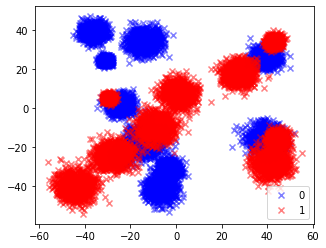

In [3]:
np.random.seed(2)
N = 1000

n_subclasses = 10
sparseness = 90
mean = np.array([-1, 1])
cov = np.matrix([[1,0],[0,1]])

def cov_variability(variability=20):
    return np.random.rand()*variability

for i in range(n_subclasses):
    mean_aux = mean + (np.random.rand(2)-0.5)*sparseness
    if i == 0:
        x = np.random.multivariate_normal(mean_aux, cov*cov_variability(), N)
    else:
        x = np.vstack((x, np.random.multivariate_normal(mean_aux, cov*cov_variability(), N)))

for i in range(n_subclasses):
    mean_aux = -mean - (np.random.rand(2)-0.5)*sparseness
    x = np.vstack((x, np.random.multivariate_normal(mean_aux, cov*cov_variability(), N)))

y = np.hstack((np.zeros(N*n_subclasses), np.ones(N*n_subclasses)))
x, y = shuffle(x, y)

plt.figure()
plot_points(x,y, alpha=0.5)

Fitting model Linear Regression
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
Accuracy = 0.05579073441841742
Fitting model Logistic Regression
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy = 0.4987
Fitting model K-Nearest Neighbors
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy = 0.9155
Fitting model Decision Tree
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state

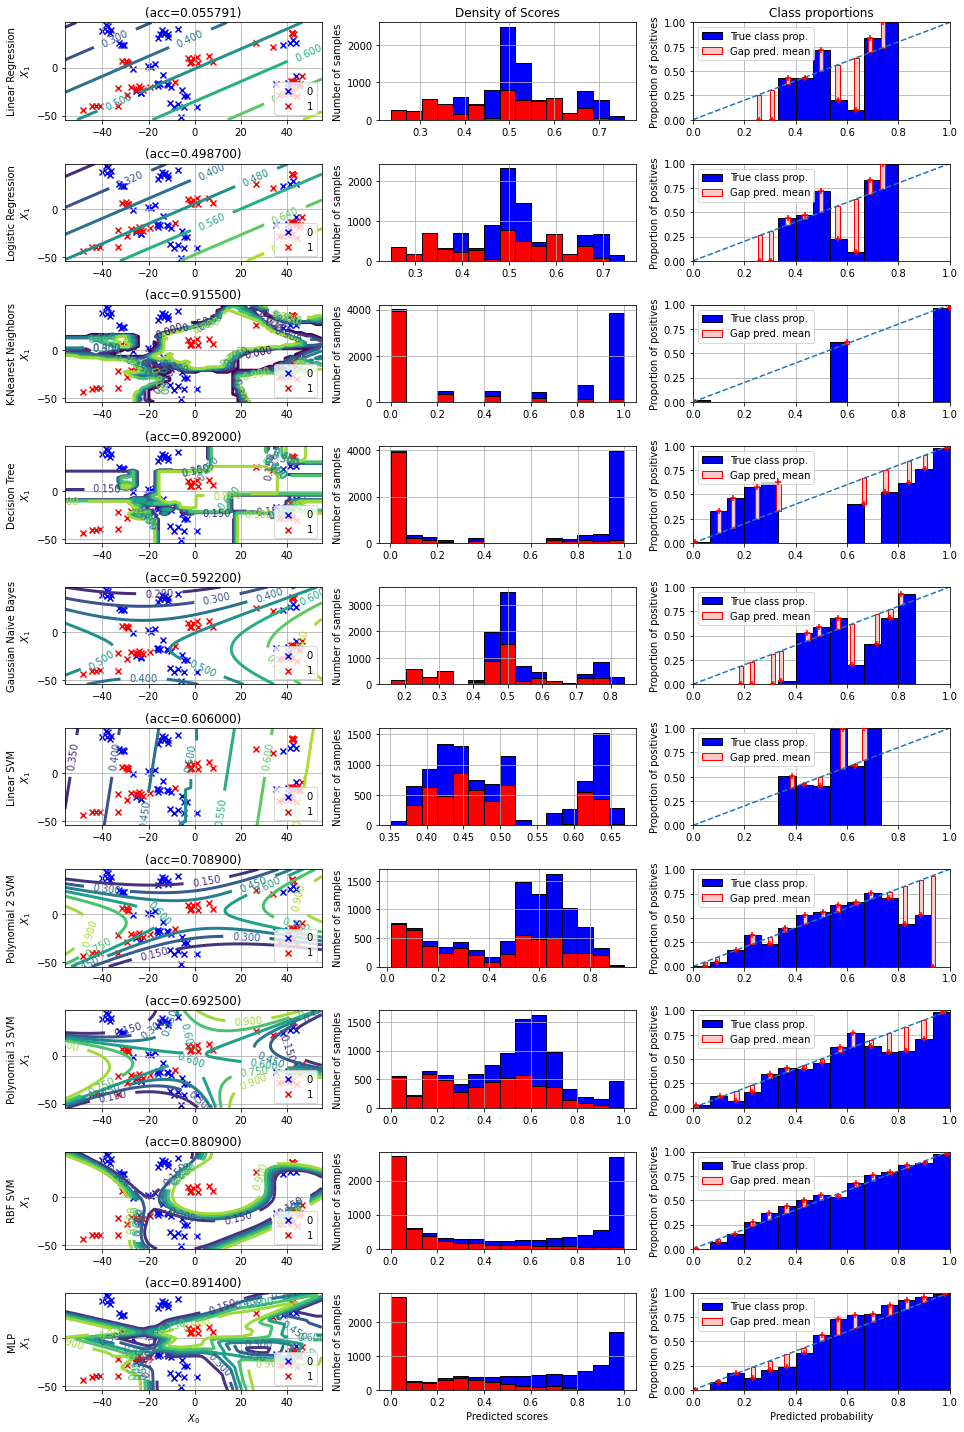

In [4]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

models = [(LinearRegression, {},"Linear Regression"),
          (LogisticRegression, {'C': 0.1},"Logistic Regression"),
          (KNeighborsClassifier, {},"K-Nearest Neighbors"),
          (MyDecisionTreeClassifier, {},"Decision Tree"),
          (GaussianNB, {},"Gaussian Naive Bayes"),
          (SVC, {'kernel':'linear', 'probability': True},"Linear SVM"),
          (SVC, {'kernel':'poly', 'degree':2, 'probability': True},"Polynomial 2 SVM"),
          (SVC, {'kernel':'poly', 'degree':3, 'probability': True},"Polynomial 3 SVM"),
          (SVC, {'kernel':'rbf', 'probability': True},"RBF SVM"),
          (MLPClassifier, {}, "MLP")]
n_models = len(models)

titles = ["Contour lines of Scores", 
          "Density of Scores",
          "Class proportions"]

fig = plt.figure(figsize=(4.5*3, 2*len(models)))
for i, title in enumerate(titles):
    plt.subplot(n_models, 3, i+1)
    plt.title(title)

def get_sets(x, y, test_fold_id, test_folds):                                   
    x_test = x[test_folds == test_fold_id, :]                                   
    y_test = y[test_folds == test_fold_id]                                      
                                                                                
    train_indices = test_folds != test_fold_id                                  
    x_train = x[train_indices, :]                                               
    y_train = y[train_indices]                                                  
                                                                                
    return [x_train, y_train, x_test, y_test]

skf = StratifiedKFold(n_splits=2)  

train_idx, val_idx = next(skf.split(x, y))
x_train = x[train_idx]
y_train = y[train_idx]
x_val = x[val_idx]
y_val = y[val_idx]

for i, (model, args, name) in enumerate(models):
    model = model(**args)
    print("Fitting model {}".format(name))
    print(model.get_params())
    model.fit(x_train,y_train)
    score = model.score(x_val, y_val)
    print("Accuracy = {}".format(score))
      
    if hasattr(model, 'predict_proba'):
        y_val_pred = model.predict_proba(x_val)[:,1]
    elif hasattr(model, 'decision_function'):
        y_val_pred = model.decision_function(x_val)
    else:
        y_val_pred = model.predict(x_val)
        
    logloss = log_loss(y_val, y_val_pred)
    
    # CONTOUR LINES
    plt.subplot(n_models,3,i*3+1)
    plt.ylabel(name + '\n$X_1$')
    plt.xlabel('$X_0$')
    plot_points(x_val[:100],y_val[:100],alpha=1.0)
    plot_contourlines(x,y,model,alpha=1)
    if i < len(models) - 1:
        plt.xlabel('')
    plt.title('(acc={:02f})'.format(score))
    
    # SCORES' DENSITY
    ax = plt.subplot(n_models,3,i*3+2)
    plot_histogram(y_val_pred, y_val, ax=ax)
    
    if i < len(models) - 1:
        plt.xlabel('')
    
    ax = plt.subplot(n_models,3,i*3+3)
    fig, ax = plot_binary_reliability_diagram_gaps(y_val, y_val_pred, n_bins=15, ax=ax)
    if i < len(models) - 1:
        plt.xlabel('')
        
plt.tight_layout()
plt.savefig('example_classifier_scores.pdf')